In [9]:
import copy
import itertools
import os
from typing import Dict, List, Union

import matplotlib
import pandas as pd
from matplotlib import pyplot as plt

import constants
import core.tools.metrics as metrics
import core.tools.rnn_prepare as rnn_prepare
import core.tools.visualize as visualize
import core.tools.param_set_generator as param_set_generator
import core.models.stacked_lstm as stacked_lstm

In [10]:
from hps_configs.mac_config import main

In [11]:
param_set = param_set_generator.gen_hparam_set(main)
param = param_set[0]
file_dir = constants.DATA_DIR["a"]

Total number of parameter sets generated: 6


In [12]:
def checkpoints(period, total):
    """
    A helpful function for individual train method.
    to generate checkpoint list with integers 
    for every PERIOD time steps and TOTAL time steps in total.
    """
    ckps = [
        period * x for x in range(1, total // period)
    ]
    return ckps

In [13]:
# Generate the dataset.
df_ready = rnn_prepare.prepare_dataset(
    file_dir=file_dir,
    periods=param["PERIODS"],
    order=param["ORDER"],
    remove=None,
    verbose=False
)

# Split dataset.
(X_train, X_val, X_test,
 y_train, y_val, y_test) = rnn_prepare.split_dataset(
    raw=df_ready,
    train_ratio=param["TRAIN_RATIO"],
    val_ratio=param["VAL_RATIO"],
    lags=param["LAGS"]
)

# The gross dataset excluding the test set.
# Excluding the test set for isolation purpose.
model_data_feed = {
    "X_train": X_train,
    "X_val": X_val,
    "y_train": y_train,
    "y_val": y_val,
}

# The checkpoint list 
ckps = checkpoints(param["epochs"] // 10, param["epochs"]) + [-1]

predictions = stacked_lstm.exec_core(
    param=param,
    data=model_data_feed,
    prediction_checkpoints=ckps
)

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64
StandardScaler applied, scaling based on the first 679 observations.
Total 842 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (842, 6, 1), y shape = (842, 1, 1)
Training and testing set generated,        
X_train shape: (672, 6, 1)        
y_train shape: (672, 1)        
X_test shape: (85, 6, 1)        
y_test shape: (85, 1)        
X_validation shape: (85, 6, 1)        
y_validation shape: (85, 1)
Resetting Tensorflow defalut graph...
Note: no gradient clipping is applied.            
If possible gradient exploding detected (e.g. nan loss), try use clip_grad.
Starting training session...
Training model...

Iteration [0], Training MSE 55.3316116; Validation MSE 38.7280807

Iteration [100], Training MSE 0.7391145; Validation MSE 0.5018409
Saving the model...
Time taken for [150] epochs:  0:00:02.653812


Final result (validation set):
Loss Summary:
	mae=0.5431802272796631
	mse=0.5109433531761169
	rmse=0.7148030400276184
	mape=3.9256246089935303


TypeError: only integer scalar arrays can be converted to a scalar index

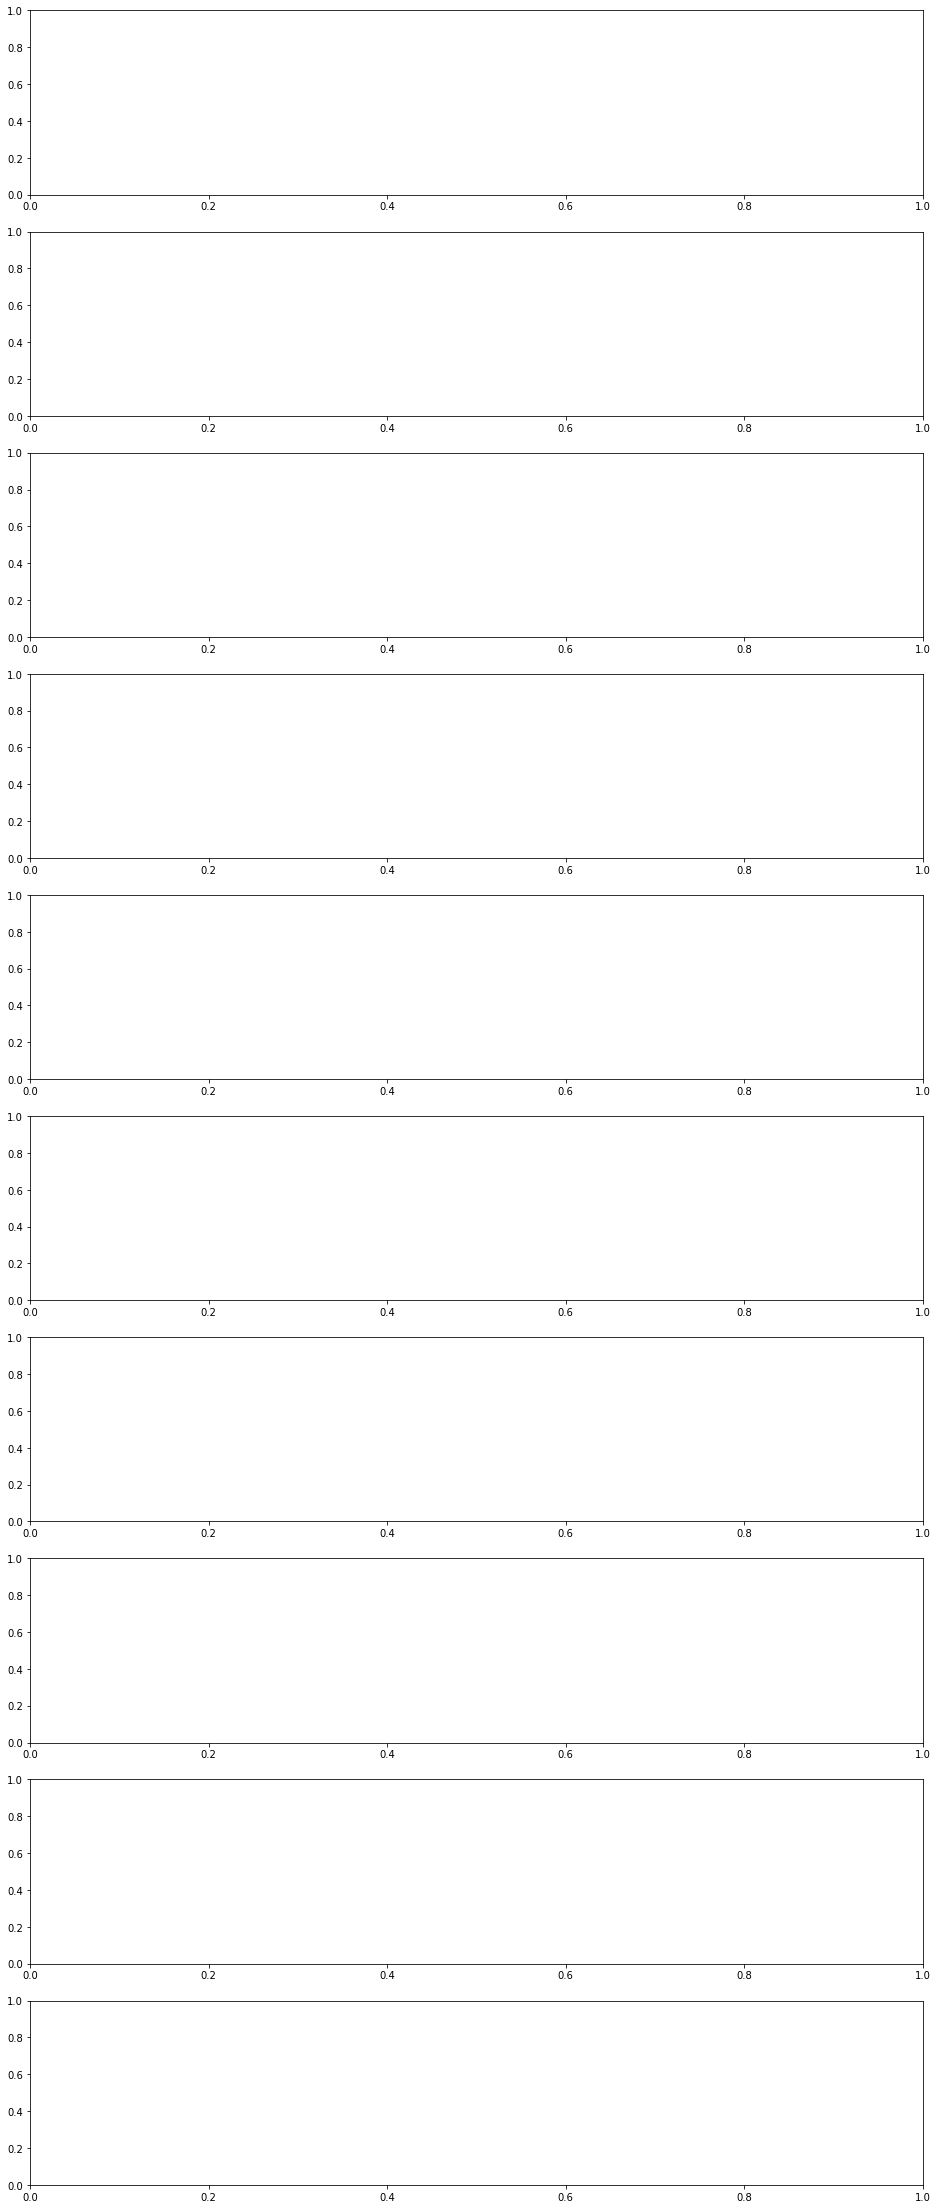

In [22]:
val_final = list(predictions.values())[-1]["val"]
print("Final result (validation set):")
metric_test = metrics.merged_scores(
    actual=pd.DataFrame(y_val),
    pred=pd.DataFrame(val_final),
    verbose=True
)

# Visualize prediction during training.
for set_name in ["train", "val"]:
    pred = dict((e, val[set_name]) for e, val in predictions.items())
    plt.close()
    fig = visualize.plot_checkpoint_individual(
        predictions=pred,
        actual=model_data_feed["y_" + set_name],
        name=set_name)

    if not os.path.exists(param["fig_path"]):
        os.makedirs(param["fig_path"])
    assert not param["fig_path"].endswith("/")
    plt.savefig(param["fig_path"] + "/" + f"pred_record_{set_name}.svg")
    plt.close()

fig = visualize.plot_checkpoint_combined(
    predictions=predictions,
    actual={"train": y_train, "val": y_val}
)
if not os.path.exists(param["fig_path"]):
    os.makedirs(param["fig_path"])
assert not param["fig_path"].endswith("/")
plt.savefig(param["fig_path"] + "/" + f"pred_record_combined.svg")
plt.close()

In [228]:
# Model Parameters
num_time_steps = LAGS
# Number of series used to predict. (including concurrent)
num_inputs = 1
num_outputs = 1
num_neurons = 2048
# Number of output series
learning_rate = 0.01
epochs = 500
# Training Settings
report_periods = epochs // 20

In [244]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_outputs])

cell = tf.nn.rnn_cell.LSTMCell(
    num_units=num_neurons)

multi_cell = tf.nn.rnn_cell.MultiRNNCell(
    [tf.nn.rnn_cell.LSTMCell(num_units=x)
    for x in [512, num_neurons]]
)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
stacked_output = tf.reshape(rnn_outputs, [-1, num_time_steps * num_neurons])

W = tf.Variable(tf.random_normal([num_time_steps * num_neurons, 1]), dtype=tf.float32)
b = tf.Variable(tf.random_normal([1]), dtype=tf.float32)

pred = tf.add(tf.matmul(stacked_output, W), b)

# pred = tf.layers.dense(stacked_output, 1)

loss = tf.losses.mean_squared_error(y, pred)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# gvs = optimizer.compute_gradients(loss)
# capped_gvs = [(tf.clip_by_value(grad, -10., 10.), var) for grad, var in gvs]
# train = optimizer.apply_gradients(capped_gvs)
train = optimizer.minimize(loss)

In [245]:
rnn_outputs

<tf.Tensor 'rnn/transpose_1:0' shape=(?, 12, 2048) dtype=float32>

In [246]:
# X_batches = X_train[:-84].reshape(100, -1, num_time_steps, num_inputs)
# y_batches = y_train[:-84].reshape(100, -1, num_outputs)
# print(X_batches.shape)
# print(y_batches.shape)

In [247]:
start = datetime.now()
hist = {"train": [], "val": []}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
#         for X_batch, y_batch in zip(X_batches, y_batches):
#             sess.run(train, feed_dict={X: X_batch, y: y_batch})
        sess.run(train, feed_dict={X: X_train, y: y_train})
        train_mse = loss.eval(feed_dict={X: X_train, y: y_train})
        val_mse = loss.eval(feed_dict={X: X_val, y: y_val})
        hist["train"].append(train_mse)
        hist["val"].append(val_mse)
        if e % report_periods == 0:
            print(
                f"\nIteration [{e}], Training MSE {train_mse:0.7f}; Validation MSE {val_mse:0.7f}")

    p_train = pred.eval(feed_dict={X: X_train})
    p_test = pred.eval(feed_dict={X: X_test})
    p_val = pred.eval(feed_dict={X: X_val})
print(f"Time taken for {epochs} epochs: ", datetime.now()-start)


Iteration [0], Training MSE 787562.6875000; Validation MSE 143769.0781250

Iteration [25], Training MSE 417.2266541; Validation MSE 300.4638977

Iteration [50], Training MSE 34.7598991; Validation MSE 16.1256237

Iteration [75], Training MSE 9.6410913; Validation MSE 4.1032758

Iteration [100], Training MSE 5.5318341; Validation MSE 2.1694579

Iteration [125], Training MSE 3.3403451; Validation MSE 1.5505639

Iteration [150], Training MSE 1.8905295; Validation MSE 0.9982395

Iteration [175], Training MSE 1.5141793; Validation MSE 0.7033575

Iteration [200], Training MSE 1.3301622; Validation MSE 0.6254877

Iteration [225], Training MSE 1.2749035; Validation MSE 0.7702165

Iteration [250], Training MSE 1.1670452; Validation MSE 0.6369624

Iteration [275], Training MSE 1.1017121; Validation MSE 0.7027410

Iteration [300], Training MSE 1.0498884; Validation MSE 0.7341468

Iteration [325], Training MSE 1.0055586; Validation MSE 0.7435285

Iteration [350], Training MSE 0.9678559; Validatio

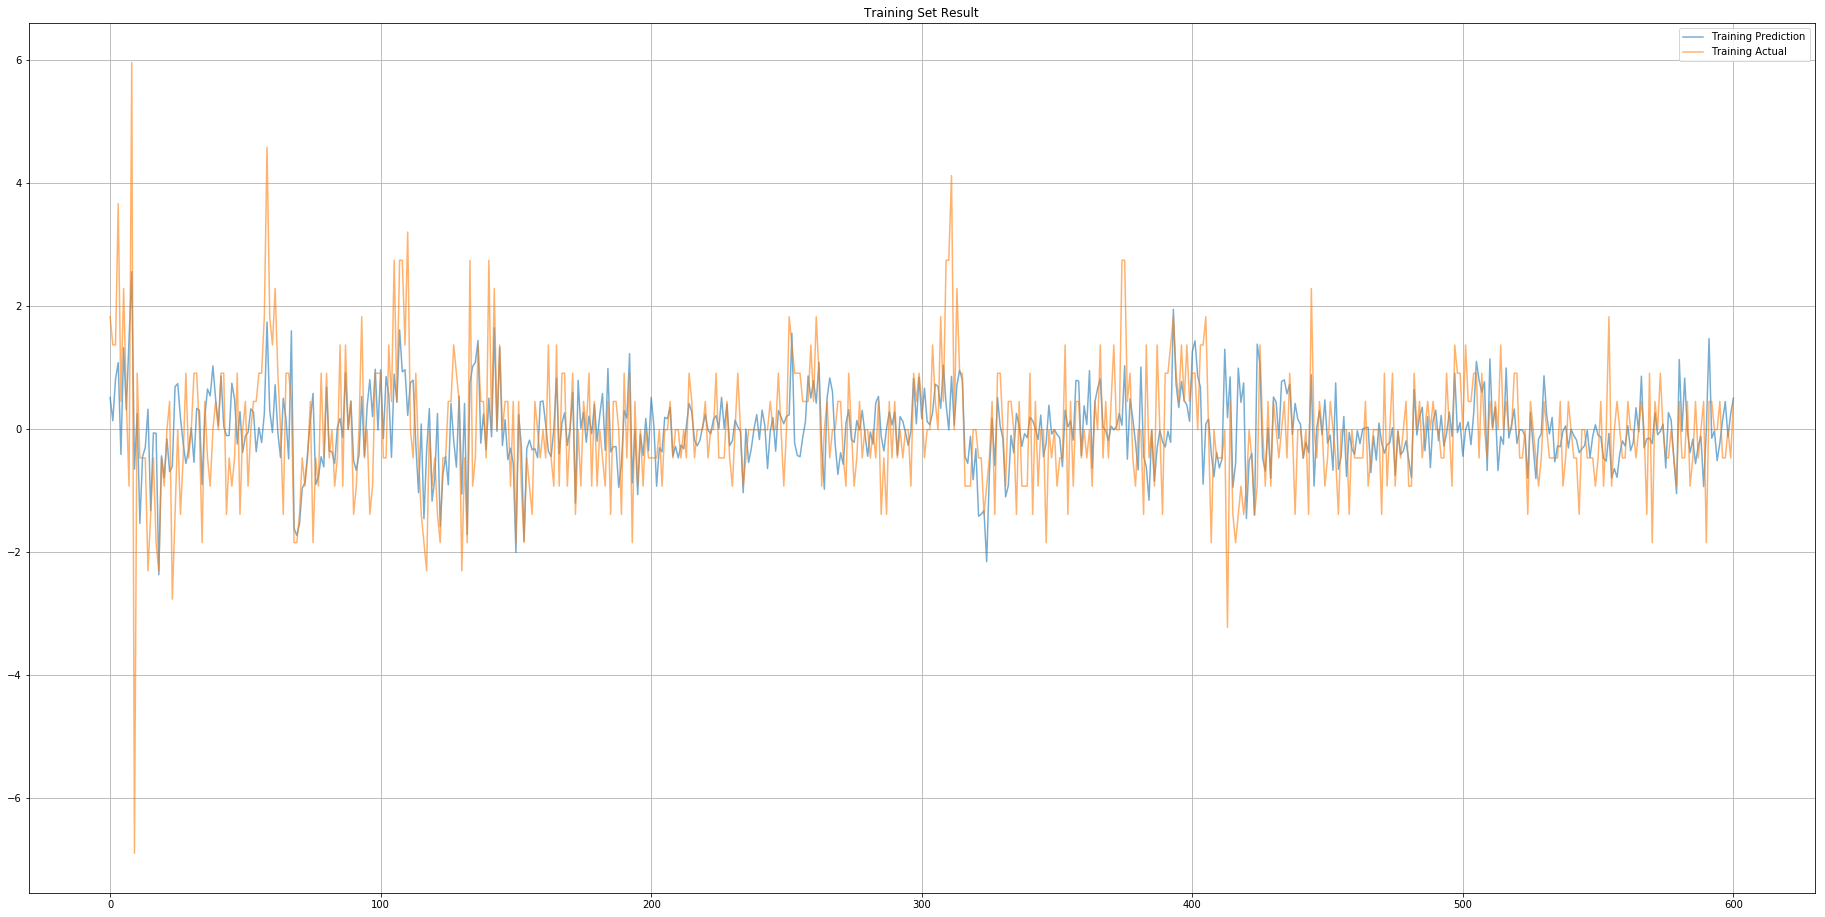

In [248]:
plt.close()
plt.figure(figsize=(32, 16))
plt.plot(p_train.reshape(-1, 1), alpha=0.6)
plt.plot(y_train.reshape(-1, 1), alpha=0.6)
plt.legend(["Training Prediction", "Training Actual"])
plt.grid(True)
plt.title("Training Set Result")
plt.show()

# plt.close()
# plt.figure(figsize=(16, 8))
# plt.plot(p_train.reshape(-1, 1)[-100:], alpha=0.6)
# plt.plot(y_train.reshape(-1, 1)[-100:], alpha=0.6)
# plt.legend(["Training Prediction", "Training Actual"])
# plt.grid(True)
# plt.title("Training Set Result: last 100")
# plt.show()

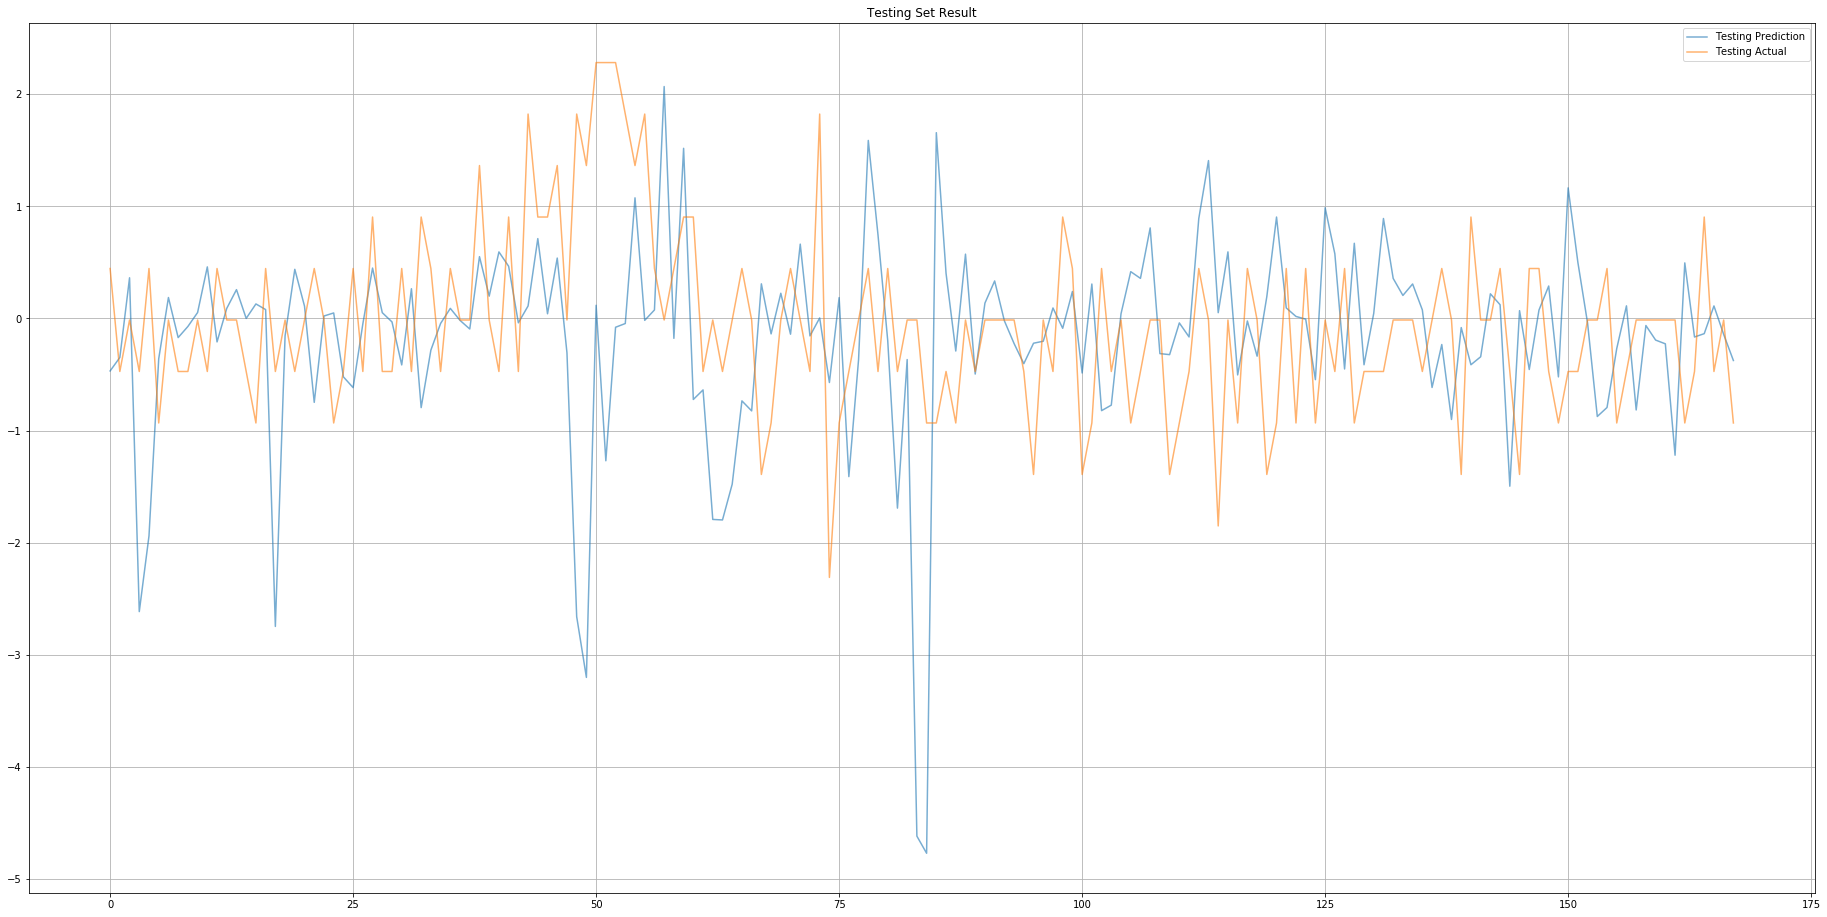

In [249]:
plt.close()
plt.figure(figsize=(32, 16))
plt.plot(p_test.reshape(-1, 1), alpha=0.6)
plt.plot(y_test.reshape(-1, 1), alpha=0.6)
plt.legend(["Testing Prediction", "Testing Actual"])
plt.grid(True)
plt.title("Testing Set Result")
plt.show()

# plt.close()
# plt.figure(figsize=(16, 8))
# plt.plot(p_test.reshape(-1, 1)[-100:], alpha=0.6)
# plt.plot(y_test.reshape(-1, 1)[-100:], alpha=0.6)
# plt.legend(["Testing Prediction", "Testing Actual"])
# plt.grid(True)
# plt.title("Testing set Result: last 100")
# plt.show()

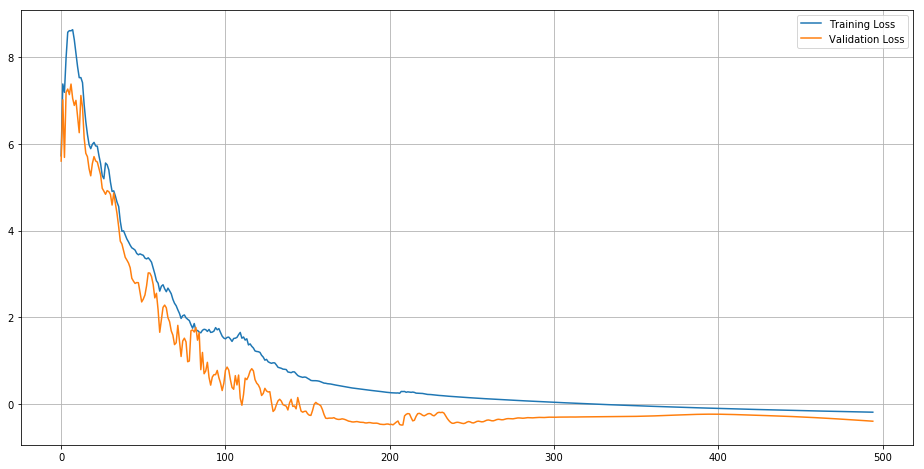

In [250]:
plt.close()
plt.figure(figsize=(16, 8))
plt.plot(np.log(hist["train"][5:]))
plt.plot(np.log(hist["val"][5:]))
plt.legend(["Training Loss", "Validation Loss"])
plt.grid(True)
plt.show()